Section 2.2: Paragraph Disparity Level Analysis

In [ ]:
import numpy as np
from icl.util_classes.arg_classes import AttrArgs
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_path='xxx'

def plot_ndarray(data, support_idxs, title_name, args, ax=None, idx=None):
    top_k=10
    names = [r'$\mathcal{I}_{p^s,q}$', r'$\mathcal{I}_{p^n,q}$', r'$\mathcal{I}_{p^s,t}$', r'$\mathcal{I}_{p^n,t}$']
    colors = ['#4682B4', '#B0C4DE', '#DAA520', '#EED28A']
    new_support_idxs = [sorted([x for idx in sample_idxs for x in (idx,idx+args.psg_num)]) 
            for sample_idxs in support_idxs]
    
    bsz=data.shape[0]
    data_focus = data[:, :2*args.psg_num, :]
    new_data=np.empty_like(data_focus)

    for sample_idx in range(data_focus.shape[0]):
        sample = data_focus[sample_idx]
        sup_idxs=new_support_idxs[sample_idx]
        
        # psg->ans
        all_indices = np.arange(args.psg_num)
        mask = ~np.isin(all_indices, sup_idxs[:len(sup_idxs)//2])
        neg_ans_indices = all_indices[mask]

        # psg->que
        all_indices = np.arange(args.psg_num,2*args.psg_num)
        mask = ~np.isin(all_indices, sup_idxs[len(sup_idxs)//2:])
        neg_que_indices = all_indices[mask]
        
        new_order = np.concatenate([sup_idxs[:len(sup_idxs)//2], neg_ans_indices, sup_idxs[len(sup_idxs)//2:], neg_que_indices])
        
        new_sample = sample[new_order]
        new_data[sample_idx] = new_sample

    proportions = {'sp_a':0, 'np_a':0, 'sp_q':0, 'np_q':0}
    for i in range(new_data.shape[0]):
        split_sup_len=len(new_support_idxs[i])//2
        proportions['sp_a']+=new_data[i,:split_sup_len,].mean(axis=0) 
        proportions['np_a']+=new_data[i,split_sup_len:args.psg_num,].mean(axis=0)
        proportions['sp_q']+=new_data[i,args.psg_num:args.psg_num+split_sup_len,].mean(axis=0) 
        proportions['np_q']+=new_data[i,args.psg_num+split_sup_len:,].mean(axis=0)
    proportions = {k: v/bsz for k,v in proportions.items()}
    proportions={k:v*top_k for k,v in proportions.items()}
    fig_data=np.array([proportions['sp_q'], proportions['np_q'], proportions['sp_a'], proportions['np_a']])
    type_num = len(names)
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure  
    fignum_map={0:'a',1:'b',2:'c'}
    for i in range(type_num):
        ax.plot(fig_data[i], label=names[i], color=colors[i]) 
    ax.legend(prop=FontProperties(fname=font_path, size=14),loc='upper left')
    ax.set_title(title_name, fontproperties=FontProperties(fname=font_path, size=22))
    ax.set_ylabel('Information flow', fontproperties=FontProperties(fname=font_path, size=16))
    ax.set_xlabel(f'Layer\n({fignum_map[idx]})', fontproperties=FontProperties(fname=font_path, size=16))
    return fig 

(990, 22, 32)
(1000, 22, 32)
(1000, 42, 32)


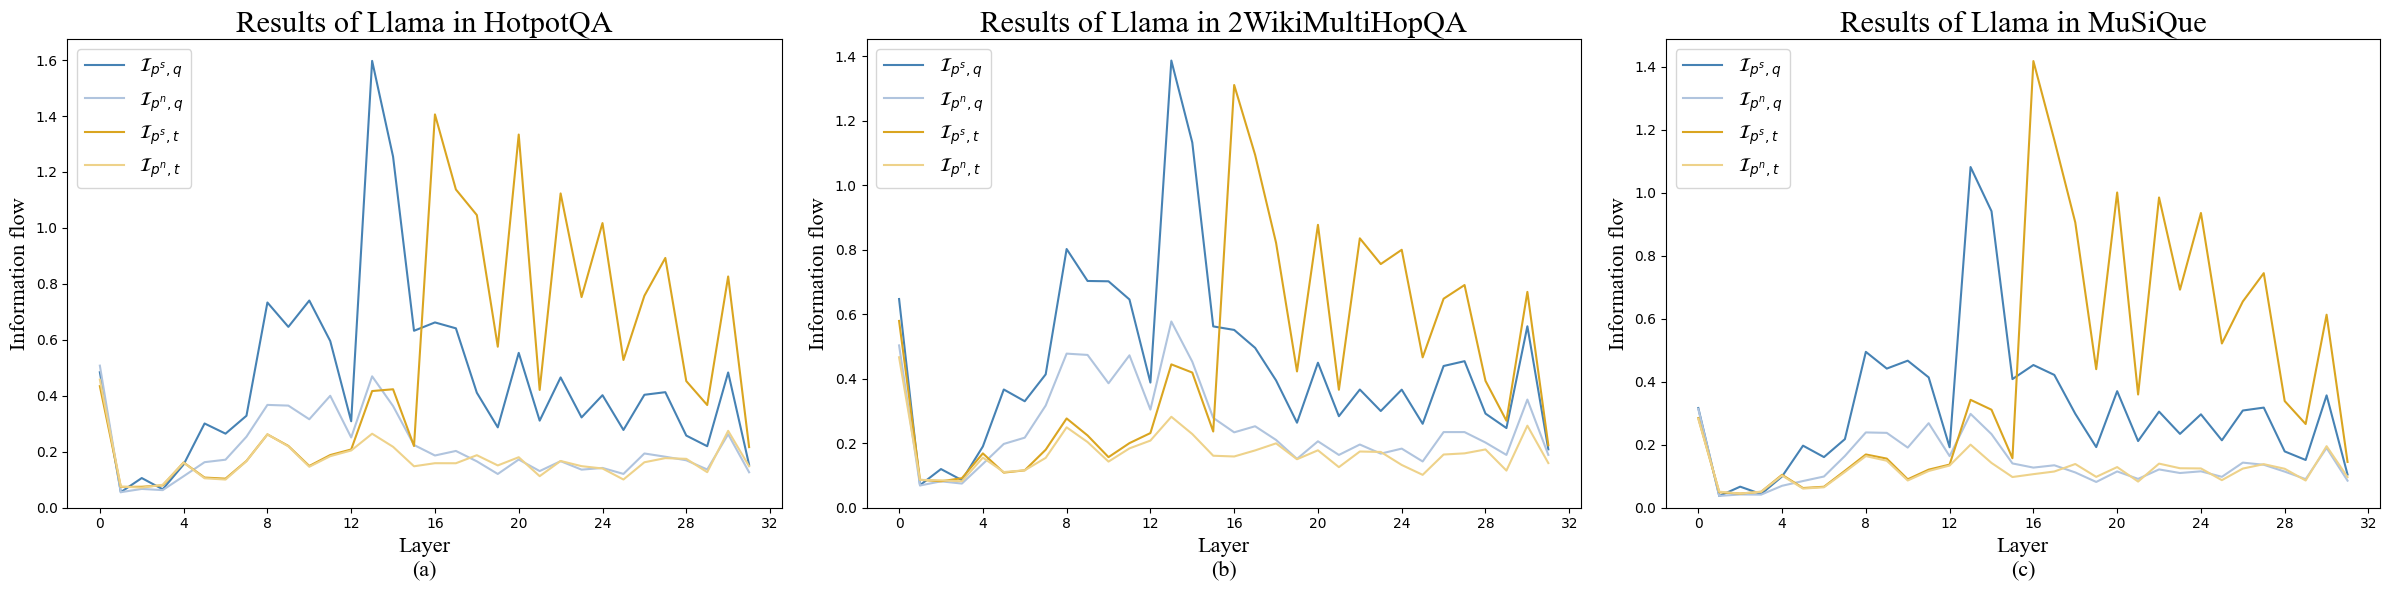

In [ ]:
model_name = 'llama-3.1-8b-instruct'    # 'qwen2.5-7b-instruct' 'llama-3.1-8b-instruct'
title_task_map={'hotpotqa':'HotpotQA','2wikimqa':'2WikiMultiHopQA','musique':'MuSiQue'}
title_model_map='Llama' if 'llama' in model_name else 'Qwen'
seed=42

import json
from matplotlib.ticker import MultipleLocator

fig, axs = plt.subplots(1, 3, figsize=(24, 6))  
tasks = ['hotpotqa', '2wikimqa', 'musique'] 
for i, task in enumerate(tasks):
    res=[]
    support_idxs=[]
    ana_args = AttrArgs(task_name=task, model_name=model_name, seeds=[seed])
    results = ana_args.load_result()
    print(results.shape)
    with open(f'{ana_args.save_file_name}.jsonl','r') as f:
        for line in f:
            res.append(json.loads(line))
    for obj in res:
        support_idxs.append(obj['support_idxs'])
    title_name = f'Results of {title_model_map} in {title_task_map[task]}'
    plot_ndarray(results, support_idxs, title_name, ana_args, ax=axs[i], idx=i)
    ystep=0.2 if title_model_map=='Llama' else 0.4
    axs[i].set_ylim(bottom=0.0)  
    axs[i].yaxis.set_major_locator(MultipleLocator(ystep))
    axs[i].xaxis.set_major_locator(MultipleLocator(4))

plt.tight_layout(w_pad=2.0)
save_file=f'results/pics/attr/{model_name}/layer_ana.pdf'
fig.savefig(save_file, bbox_inches='tight')